## From PyTorch to Keras

In [1]:
import torch
import numpy as np
import torchvision.models


from pathlib import Path
from torch.utils import model_zoo
from torch.autograd import Variable
from pytorch2keras.converter import pytorch_to_keras

Using TensorFlow backend.


In [2]:
import torchvision.models
from torch.utils import model_zoo

#### Important:
Run "vscodium ~/.keras/keras.json" or code editor of your choice to set "image_data_format" to "channel_first" instead of "channel_last" (standard setting)

    {
        "floatx": "float32",
        "epsilon": 1e-07,
        "backend": "tensorflow",
        "image_data_format": "channels_first"
    }

Download pretrained [Stylenet](https://github.com/rgeirhos/texture-vs-shape/blob/master/models/load_pretrained_models.py), a ReNet-50 trained on [Stylized ImageNet](https://github.com/rgeirhos/texture-vs-shape):

In [9]:
! wget -q -c https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/6f41d2e86fc60566f78de64ecff35cc61eb6436f/resnet50_train_60_epochs-c8e5653e.pth.tar -O data/stylenet.pth.tar

In [10]:
! tar -zxf data/stylenet.pth.tar -C data/


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


Download pretrained [ResNet-50](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18) trained on regular ImageNet:

In [3]:
! wget -q -c https://download.pytorch.org/models/resnet50-19c8e357.pth -O data/resnet50.pth

Load PyTorch model:

In [3]:
save_path = Path("data/")

In [4]:
model = torchvision.models.resnet50(pretrained=False)

model = torch.nn.DataParallel(model)
modelCheckpoint = torch.load(save_path / "stylenet.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict(modelCheckpoint['state_dict'])
#model.eval()

<All keys matched successfully>

In [39]:
model = torchvision.models.resnet50(pretrained=False)
model.load_state_dict(torch.load(save_path / "resnet50.pth"))
#model.eval()

<All keys matched successfully>

Create a dummy variable with correct shape:

In [40]:
# our input variable is going to be a 3 channel RGB picture
# with h=224 pixels and w=224 pixels
input_np = np.random.uniform(0, 1, (1, 3, 224, 224))
input_var = Variable(torch.FloatTensor(input_np))

In [41]:
np.shape(input_np)

(1, 3, 224, 224)

In [42]:
np.shape(input_var)

torch.Size([1, 3, 224, 224])

We use the dummy-variable to trace the model (with `jit.trace`):

In [43]:
%%capture

# we should specify shape of the input tensor
k_model = pytorch_to_keras(model, input_var, [(3, 224, 224,)], verbose=True)  

Instructions for updating:
Colocations handled automatically by placer.


Delete 'model' to set memory free

In [49]:
del model

So did it work?

In [44]:
type(k_model)

keras.engine.training.Model

### Save the keras model to disk

Option 1:
    - Use seperate files for architecture and weights

In [45]:
# Save the weights
k_model.save_weights(save_path / 'resnet_weights.h5')

# Save the model architecture
with open(save_path / 'resnet_architecture.json', 'w') as f:
    f.write(k_model.to_json())

Option 2:
    - Use one file for both (preferred)

In [46]:
# Creates a HDF5 file 'my_model.h5'
k_model.save(save_path / 'resnet.h5')

# Deletes the existing model
del k_model

________________

## Check if everthing works

In [13]:
from scipy.special import softmax
from torchvision import transforms
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

In [7]:
save_path = Path("data/")

In [8]:
# Returns a compiled model identical to the previous one
k_model = load_model(save_path / 'resnet.h5')

Instructions for updating:
Colocations handled automatically by placer.


/home/malte/anaconda3/envs/kerasCPU/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
train_transforms = transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor()])

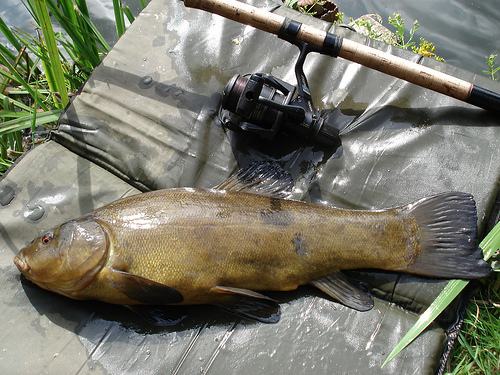

In [10]:
img = load_img(save_path / "imagenette2/val/n01440764/ILSVRC2012_val_00009111.JPEG")
img

In [14]:
output = k_model.predict(np.array(train_transforms(img)[np.newaxis, :]))
output_class = np.argmax(output)
output_class

0

In [8]:
softmax(output)[0][output_class]

0.8692162